# Batch Normalization – Lección 


__Créditos__

Este material es parte integral del programa académico de Udacity "Deep Learning Nanodegree Foundation" (https://github.com/udacity/deep-learning) y fue adaptado al español con propósito de ser un ejemplo práctico del desempeño de Batch normalization.

__Contenido__

1. [Definición](#theory)
2. [Beneficios](#benefits)
3. [Implementación](#implementation_1)
4. [Práctica](#demos)
5. [Un enfoque más detallado](#implementation_2)

# ¿Qué es Batch Normalization?<a id='theory'></a>

Se reconoce que el término __batch normalization__ fue nombrado por primera vez por Sergey Ioffe y Christian Szegedy en 2015 [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). La idea principal es que en vez de únicamente normalizar las entradas a la red neuronal, se normalicen las entradas a las capas ocultas en la red (hidden layers). Se le denomina "batch" normalization porque, durante el entrenamiento, se normalizan las entradas en cada capa utilizando el promedio y desviación estándar de los valores en el grupo (mini-batch) en el que se está trabajando.

¿Por qué ayuda? Bueno, ya sabemos que normalizar las entradas a una red ayuda a que la red aprenda. Pero una red es un conjunto de capas, en donde la salida de una capa se convierte en la entrada de otra capa. Es decir, podemos imaginar cada capa en la red neuronal como la primer capa de un conjunto de capas que podemos ver como una red neuronal más pequeña. 

Por ejemplo, imaginaque tienes una red de 3 capas. En lugar de pensar en ella como una red única con entradas, capas y salidas, piensa que la salida de la capa 1 es la entrada de la capa 2.Éstas redes serán las capas l y 2 de nuestra red original.  

De la misma forma, la saluda de la capa 2 puede imaginarse como la entrada a una red adicional. 

Cuando se piensa de esa manera, es más fácil imaginar el beneficio de normalizar las entradas en cada capa. Es como normalizar las entradas en otra red neuronal pero en realidad lo estás haciendo en una subred (sub-network).

Adicional a las razones intuitivas, existen explicaciones matemáticas que permiten describir como funcionará mejor una red neuronal. Lo anterior, permite combatir lo que los autores llaman _internal covariate shift_ descrita en la [referencia](https://arxiv.org/pdf/1502.03167.pdf) y en el libro de [Deep Learning](http://www.deeplearningbook.org) escrito por Ian Goodfellow, Yoshua Bengio, y Aaron Courville, específicamente en el [Capítulo 8: Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html).

# Beneficios de Batch Normalization<a id="benefits"></a>

Batch normalization optimiza el entrenamiento de la red neuronal artificial. Se ha demostrado que tiene los siguientes beneficios:
1. **Las redes se entrenan más rápido** – Cada iteración de entrenamiento será más lenta debido a los cálculos adicionales durante el forward pass y los hiperparámetros adicionales para entrenar el back propagation. Sin embargo, convergerá más rápido, por lo que el entrenamiento será más rápido también. 
2. **Permite índices de aprendizaje (learning rates) más altos** – El descenso gradiente usualmente requiere pequeños __learning rates__ para que la red converja. Y conforme la red se profundiza, sus gradientes se minimizan durante el __back propagation__ por lo cual requiere más iteraciones. Utilizar __batch normalization__ permite utilizar mayores __learning rates__, que acelerarán la velocidad de entrenamiento de la red. 
3. **Facilita la inicialización de pesos** – La inicialización de pesos (weights) se puede complicar con redes profundas. Batch normalization simplifica la selección de los pesos iniciales.  
4. **Incrementa la disponibilidad de funciones de activación** – Hay funciones de activación que no se desempeñarán bien en algunas situaciones. Las sigmoides pierden su gradiente muy rápido, es decir que no se pueden utilizar en redes profundas. Y las funciones ReLU usualmente no terminan el entrenamiento, es decir que detienen el aprendizaje por completo, por lo que debemos ser cuidadosos en el conjunto de valores con el que las alimentamos. Batch normalization regula los valores que van a cada función de activación, y no-linearidades (non-linearlities) que parecen no funcionar bien en redes profundas vuelven a ser viables otra vez.  
5. **Provee una parte de regularización** – Batch normalization adiciona algo de ruido a tu red. En algunos casos, como en módulos de incepción (__Inception modules__, que son básicamente modelos pequeños dentro de un modelo mayor), batch normalization ha demostrado un desempeño similar a __dropout__. Pero en general, considere batch normalization como un regularizador adicional que permite sustituir algunos dropouts en tu red. 

# Batch Normalization en TensorFlow<a id="implementation_1"></a>

A continuación se muestra una manera de utilizar batch normalization en una red neuronal utilizando TensorFlow. 

La base de datos que utilizaremos para este ejemplo es [MNIST](http://yann.lecun.com/exdb/mnist/).

In [4]:
# Importa librerías
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Importa la base de datos
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Clases de redes neuronales para pruebas

La siguiente clase, `NeuralNet`, permite crear redes neuronales artificiales idénticas con/sin batch normalization. 

*Acerca de este código:*
>Esta clase no significa que represente las mejores prácticas en TensorFlow sino el diseño que soporta la argumentación establecida de batch normalization.

>Note que se utiliza la bien conocida base de datos MNIST para estos ejemplos, pero las redes que creamos no tienen la intención de desempeñarse adecuadamente para el reconocimiento de números escritos a mano. El autor eligió esta arquitectura poprque es similar a la utilizada en la publicación original, que es lo suficientemente práctica para demostrar los beneficios de utilizar batch normalization.

In [2]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        """
        Initializes this object, creating a TensorFlow graph using the given parameters.
        
        :param initial_weights: list of NumPy arrays or Tensors
            Initial values for the weights for every layer in the network. We pass these in
            so we can create multiple networks with the same starting weights to eliminate
            training differences caused by random initialization differences.
            The number of items in the list defines the number of layers in the network,
            and the shapes of the items in the list define the number of nodes in each layer.
            e.g. Passing in 3 matrices of shape (784, 256), (256, 100), and (100, 10) would 
            create a network with 784 inputs going into a hidden layer with 256 nodes,
            followed by a hidden layer with 100 nodes, followed by an output layer with 10 nodes.
        :param activation_fn: Callable
            The function used for the output of each hidden layer. The network will use the same
            activation function on every hidden layer and no activate function on the output layer.
            e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        # Distingue cuando la red utiliza batch normalization.
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm"

        # Batch normalization necesita utilizar diferentes cálculos duante el entrenamiento e inferencia,
        # por lo que utilizamos este apuntador para que le diga al gráfico que comportamiento usar.
        self.is_training = tf.placeholder(tf.bool, name="is_training")

        # Esta lista es para guardar los datos que vamos a graficar más adelante.
        # No tiene nada que ver con redes o batch normalization.
        self.training_accuracies = []

        # Crea el gráfico de la red, pero no tendrá valores reales hasta el entrenamiento o la prueba
        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        """
        Build the graph. The graph still needs to be trained via the `train` method.
        
        :param initial_weights: list of NumPy arrays or Tensors
            See __init__ for description. 
        :param activation_fn: Callable
            See __init__ for description. 
        """
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_fn)    
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
   
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):
        """
        Creates a standard, fully connected layer. Its number of inputs and outputs will be
        defined by the shape of `initial_weights`, and its starting weight values will be
        taken directly from that same parameter. If `self.use_batch_norm` is True, this
        layer will include batch normalization, otherwise it will not. 
        
        :param layer_in: Tensor
            The Tensor that feeds into this layer. It's either the input to the network or the output
            of a previous layer.
        :param initial_weights: NumPy array or Tensor
            Initial values for this layer's weights. The shape defines the number of nodes in the layer.
            e.g. Passing in 3 matrix of shape (784, 256) would create a layer with 784 inputs and 256 
            outputs. 
        :param activation_fn: Callable or None (default None)
            The non-linearity used for the output of the layer. If None, this layer will not include 
            batch normalization, regardless of the value of `self.use_batch_norm`. 
            e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
        """
        # Únicamente utilice batch normalization cuando se le solicite. No la use en la capa final,
        # la cual se identifica por no tener función de activación.
        if self.use_batch_norm and activation_fn:
            # Batch normalization utiliza pesos usuales, pero NO adiciona bias. Esto es porque sus cálculos 
            # incluyen las variables gamma y beta que vuelven innecesario el término bias.
            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)

            # Aplique batch normalization a la combinación lineal de entradas y pesos
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)

            # Ahora aplique la función de activación, *después* la normalización.
            return activation_fn(batch_normalized_output)
        else:
            # Cuando no utilice batch normalization, cree una capa standard que multiplique las entradas y pesos,
            # agregue un término de bias, y opcionalmente transmita el resultado por medio de una función de activación.  
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            return linear_output if not activation_fn else activation_fn(linear_output)

    def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):
        """
        Trains the model on the MNIST training dataset.
        
        :param session: Session
            Used to run training graph operations.
        :param learning_rate: float
            Learning rate used during gradient descent.
        :param training_batches: int
            Number of batches to train.
        :param batches_per_sample: int
            How many batches to train before sampling the validation accuracy.
        :param save_model_as: string or None (default None)
            Name to use if you want to save the trained model.
        """
        # Este apuntador almacenará las etiquetas para cada mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Defina la pérdida y el optimizador
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))
        
        # Defina las operaciones de prueba
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        if self.use_batch_norm:
            # Si no incluimos las operaciones de actualización como dependencias en la etapa de entrenamiento, 
            # las capas tf.layers.batch_normalization no actualizarán su población estadística,
            # lo que causará que el modelo falle en el tiempo de inferencia
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
        # Entrena para el número apropiado de batches. (tqdm se utiliza para desplegar el tiempo)
        for i in tqdm.tqdm(range(training_batches)):
            # Utilizamos grupos (batches) de 60 por el diseño de la publicación original. Puedes cambiar este parámetro.
            batch_xs, batch_ys = mnist.train.next_batch(60)
            session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                               labels: batch_ys, 
                                               self.is_training: True})
        
            # Evalúa el desempeño periódicamente sobre las 5k imágenes de validación y almacena el resultado para graficarlo después.
            if i % batches_per_sample == 0:
                test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                                 labels: mnist.validation.labels,
                                                                 self.is_training: False})
                self.training_accuracies.append(test_accuracy)

        # Después de entrenar, reporta el desempeño sobre los datos de evaluación
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                         labels: mnist.validation.labels,
                                                         self.is_training: False})
        print('{}: After training, final accuracy on validation set = {}'.format(self.name, test_accuracy))

        # Si quieres utilizar este modelo después para inferencia en lugar de tener que re-entrenar la red,
        # únicamente constrúyelo con los mismos parámetros y después pasa este archivo a la función 'test'
        if save_model_as:
            tf.train.Saver().save(session, save_model_as)

    def test(self, session, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):
        """
        Trains a trained model on the MNIST testing dataset.

        :param session: Session
            Used to run the testing graph operations.
        :param test_training_accuracy: bool (default False)
            If True, perform inference with batch normalization using batch mean and variance;
            if False, perform inference with batch normalization using estimated population mean and variance.
            Note: in real life, *always* perform inference using the population mean and variance.
                  This parameter exists just to support demonstrating what happens if you don't.
        :param include_individual_predictions: bool (default True)
            This function always performs an accuracy test against the entire test set. But if this parameter
            is True, it performs an extra test, doing 200 predictions one at a time, and displays the results
            and accuracy.
        :param restore_from: string or None (default None)
            Name of a saved model if you want to test with previously saved weights.
        """
        # Este apuntador almacenará las etiquetas para cada mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Defina las operaciones para evaluación
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # De ser necesario, reconstruya desde un modelo previamente guardado
        if restore_from:
            tf.train.Saver().restore(session, restore_from)

        # Evalúe nuevamente desde los datos de prueba de MNIST
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                         labels: mnist.test.labels,
                                                         self.is_training: test_training_accuracy})
        print('-'*75)
        print('{}: Accuracy on full test set = {}'.format(self.name, test_accuracy))

        # También puede evaluar el desempeño con valores individuales en lugar de batches
        if include_individual_predictions:
            predictions = []
            correct = 0

            # Haga 200 predicciones, 1 a la vez
            for i in range(200):
                # Esta es una predicción normal que utiliza valores individuales. Note que sustituimos
                # `test_training_accuracy` a `feed_dict` y el valor `self.is_training`.
                pred, corr = session.run([tf.arg_max(self.output_layer,1), accuracy],
                                         feed_dict={self.input_layer: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    self.is_training: test_training_accuracy})
                correct += corr

                predictions.append(pred[0])

            print("200 Predictions:", predictions)
            print("Accuracy on 200 samples:", correct/200)


Agregamos batch normalization a capas de la función `fully_connected`. Algunos puntos importantes son:
1. Las capas con batch normalization no tienen bias.
2. Utilizamos la función de TensorFlow [`tf.layers.batch_normalization`](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization). 
3. Agregamos la normalización **antes** de llamar a la función de activación.

# Demos de Batch Normalization <a id='demos'></a>
Esta sección entrena varias redes con/sin batch normalization para demostrar los beneficios mencionados. 

__Créditos__
[Implementing Batch Normalization in TensorFlow](http://r2rt.com/implementing-batch-normalization-in-tensorflow.html). 

## Código para soportar las pruebas

Las siguientes funciones permiten soportar las pruebas corridas en este notebook. 

La primera función, `plot_training_accuracies`, únicamente grafica los valores encontrados en las listas `training_accuracies` de los objetos proporcionados por `NeuralNet`. Si vemos la función `train` en `NeuralNet`, observarás que mientras se entrena la red, periódicamente se mide la eficiencia de la validación y se almacenan los resultados en la lista, la cual se utilizará para graficar más adelante.

La segunda función, `train_and_test`, crea dos redes neuronales - una con batch normalization y otra sin batch normalization. Después las entrena y prueba, y `plot_training_accuracies` grafica su desempeño. Lo realmente importante de esta función es que inicializa los pesos iniciales de las redes fuera de las redes y después las incluye. Esto permite entrenar la red al tiempo que inicializa los pesos, lo cual elimina diferencias de desempeño que pueden resultar de pesos iniciales desafortunados.

In [3]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `batches_per_sample` is the only
        one we look for. It should match the `batches_per_sample` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies)*batches_per_sample,batches_per_sample),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches=50000, batches_per_sample=500):
    """
    Creates two networks, one with and one without batch normalization, then trains them
    with identical starting weights, layers, batches, etc. Finally tests and plots their accuracies.
    
    :param use_bad_weights: bool
        If True, initialize the weights of both networks to wildly inappropriate weights;
        if False, use reasonable starting weights.
    :param learning_rate: float
        Learning rate used during gradient descent.
    :param activation_fn: Callable
        The function used for the output of each hidden layer. The network will use the same
        activation function on every hidden layer and no activate function on the output layer.
        e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
    :param training_batches: (default 50000)
        Number of batches to train.
    :param batches_per_sample: (default 500)
        How many batches to train before sampling the validation accuracy.
    """
    # Utiliza valores idénticos de pesos iniciales en cada red para eliminar diferencias en
    # weight initialization como causa de diferencias vistas en el desempeño del entrenamiento 
    #
    # Nota: La red utilizará estos pesos para definir el número y formas de sus capas.
    #       El batch normalization original utiliza 3 hidden layers con 
    #       100 nodes en cada capa, seguido de una capa de salida de 10 nodes.
    #       Puedes modificar estos valores pero el tañamo de la entrada siempre debe ser de 784 y la salida de 10.
    if use_bad_weights:
        # Estos pesos tienen una desviación estándar grande
        weights = [np.random.normal(size=(784,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,10), scale=5.0).astype(np.float32)
                  ]
    else:
        # Estos pesos tienen una desviación estándar pequeña
        weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
                  ]

    # Solo para comprobar que la gráfica predefinida de TensorFlow está vacía antes de iniciar otra evaluación.
    tf.reset_default_graph()

    # crea dos versiones de la misma red (con/sin batch normalization)
    nn = NeuralNet(weights, activation_fn, False)
    bn = NeuralNet(weights, activation_fn, True)
    
    # entrena y prueba los dos modelos
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        nn.train(sess, learning_rate, training_batches, batches_per_sample)
        bn.train(sess, learning_rate, training_batches, batches_per_sample)
    
        nn.test(sess)
        bn.test(sess)
    
    # Despliega uns gráfica de como cambia la exactitud de validaciones durante el entrenaiento 
    # por lo que podemos comparar como fueron entrenados los modelos y cuando convergieron
    plot_training_accuracies(nn, bn, batches_per_sample=batches_per_sample)


## Comparaciones entre redes idénticas, con/sin batch normalization

Las siguientes líneas de código entrenan redes con varias ajustes para mostrar las diferencias con/sin batch normalization. Se pretende demostrar claramente sus efectos.

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 0.01, y pesos de inicialización razonables.**

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:48<00:00, 296.28it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.975600004196167


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:56<00:00, 211.01it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9800000190734863
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9743000268936157
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9800999760627747


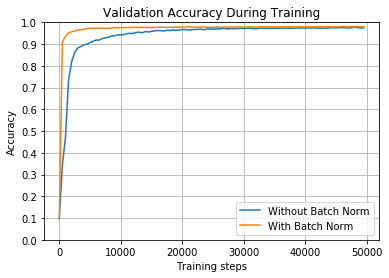

In [4]:
train_and_test(False, 0.01, tf.nn.relu)

Como se esperaba, ambas redes neuronales entrenaron bien y eventualmente alcanzaron valores similares en la prueba. Sin embargo, note que el modelo con batch normalization converge más rápido que el otro modelo, alcanzando una exactitud del 90% casi inmediatamente y alcanzando su máximo resultado en 10 o 15 mil iteraciones. La otra red utiliza alrededor de 3 mil iteraciones para alcanzar el 90% y su mejor desempeño lo hace en 30 mil o más iteraciones.

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 0.01, y pesos de inicialización razonables. El entrenamiento tiene 2000 iteraciones.**

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 226.05it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8483999967575073


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 156.35it/s]


With Batch Norm: After training, final accuracy on validation set = 0.95660001039505
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8427000045776367
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9509999752044678


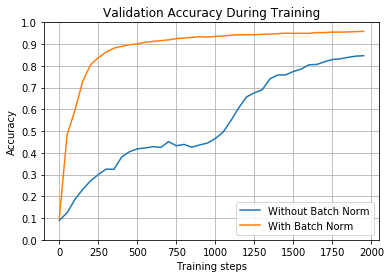

In [5]:
train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación Sigmoide, un learning rate de 0.01, y pesos de inicialización razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:56<00:00, 282.90it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8015999794006348


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:00<00:00, 207.84it/s]


With Batch Norm: After training, final accuracy on validation set = 0.975600004196167
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8043000102043152
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9736999869346619


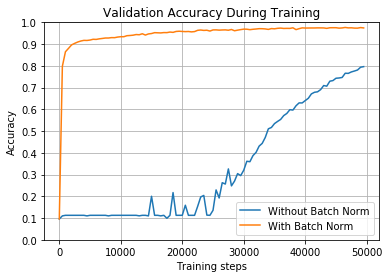

In [6]:
train_and_test(False, 0.01, tf.nn.sigmoid)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 1, y pesos de inicialización razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:50<00:00, 292.96it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:52<00:00, 215.21it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9847999811172485
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9835000038146973


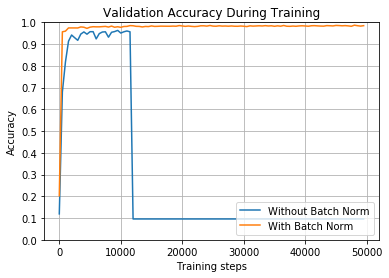

In [7]:
train_and_test(False, 1, tf.nn.relu)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:52<00:00, 289.13it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.10999999940395355


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:59<00:00, 208.42it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9825999736785889
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.10279999673366547
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9824000000953674


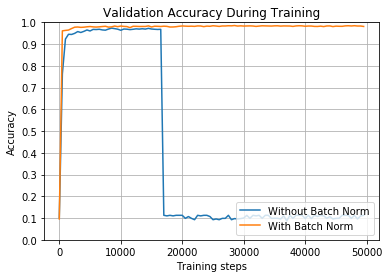

In [8]:
train_and_test(False, 1, tf.nn.relu)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación Sigmoide, un learning rate de 1, y pesos de inicialización razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:56<00:00, 283.45it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9778000116348267


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:59<00:00, 241.67it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9814000129699707
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9782000184059143
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9815999865531921


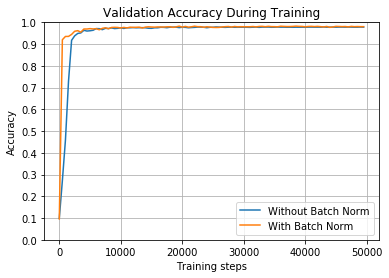

In [9]:
train_and_test(False, 1, tf.nn.sigmoid)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.77it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9247999787330627


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 149.87it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9390000104904175
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9200999736785889
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9363999962806702


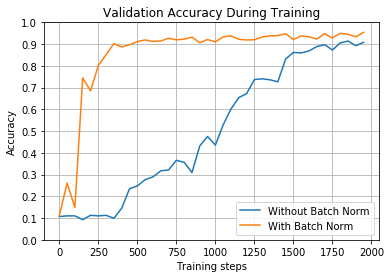

In [10]:
train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 2, y pesos de inicialización razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:53<00:00, 288.53it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.09239999949932098


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:56<00:00, 211.68it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9811999797821045
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09740000218153
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9818999767303467


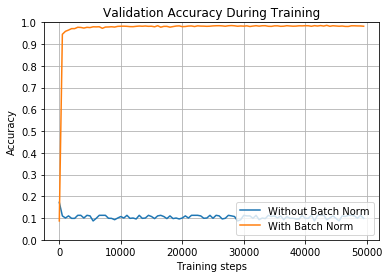

In [11]:
train_and_test(False, 2, tf.nn.relu)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación Sigmoide, un learning rate de 2, y pesos de inicialización razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:56<00:00, 282.82it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9783999919891357


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:01<00:00, 207.04it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9843999743461609
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.977400004863739
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9800000190734863


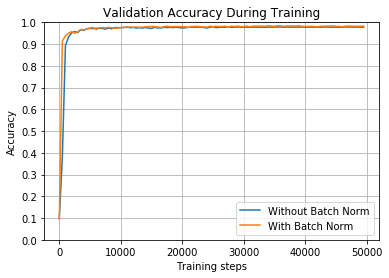

In [12]:
train_and_test(False, 2, tf.nn.sigmoid)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 222.54it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.953000009059906


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 152.98it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9589999914169312
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9459999799728394
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9550999999046326


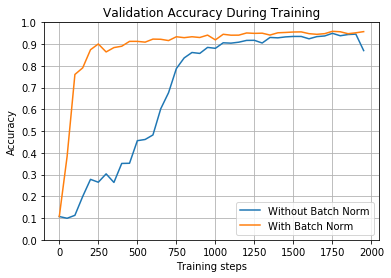

In [13]:
train_and_test(False, 2, tf.nn.sigmoid, 2000, 50)

En los siguientes ejemplos, utilizamos pesos no razonables. Es decir, normalmente utilizaríamos valores muy pequeños cercanos a cero. Sin embargo, en estos ejemplos utilizamos valores aleatorios con una desviación estándar de 5. Este ejemplo comprueba la eficiencia de batch normalization.

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 0.01, y pesos de inicialización no razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:53<00:00, 287.72it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999871253967


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:00<00:00, 207.71it/s]


With Batch Norm: After training, final accuracy on validation set = 0.7904000282287598
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.7919999957084656


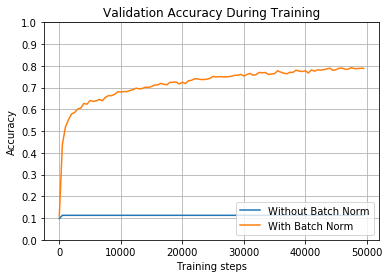

In [14]:
train_and_test(True, 0.01, tf.nn.relu)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación Sigmoide, un learning rate de 0.01, y pesos de inicialización no razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:01<00:00, 275.60it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.2248000055551529


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:21<00:00, 191.12it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8569999933242798
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.2320999950170517
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8561000227928162


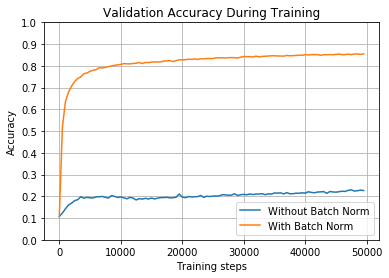

In [15]:
train_and_test(True, 0.01, tf.nn.sigmoid)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 1, y pesos de inicialización no razonables.**<a id="successful_example_lr_1"></a>

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:57<00:00, 281.61it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:01<00:00, 206.71it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8288000226020813
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8258000016212463


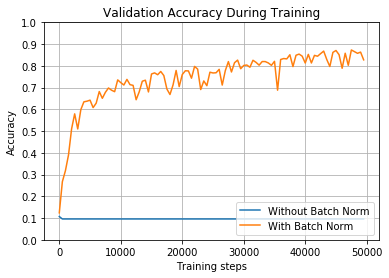

In [16]:
train_and_test(True, 1, tf.nn.relu)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación Sigmoide, un learning rate de 1, y pesos de inicialización no razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:57<00:00, 281.66it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9061999917030334


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:03<00:00, 205.55it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9553999900817871
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9003000259399414
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9532999992370605


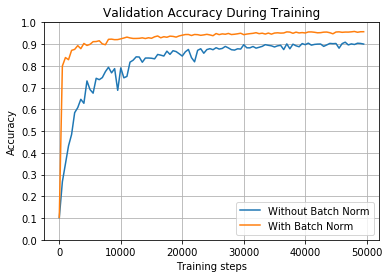

In [17]:
train_and_test(True, 1, tf.nn.sigmoid)

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 2, y pesos de inicialización no razonables.**<a id="successful_example_lr_2"></a>

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:55<00:00, 285.64it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:49<00:00, 218.00it/s]


With Batch Norm: After training, final accuracy on validation set = 0.09759999811649323
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.10320000350475311


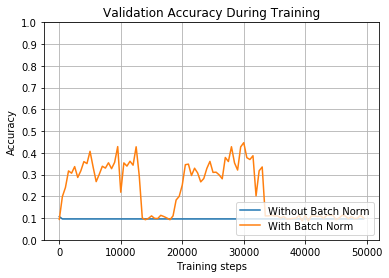

In [18]:
train_and_test(True, 2, tf.nn.relu)

Hemos visto que la función de activación ReLU no se desempeña tan bien como una Sigmoide con learning rates más altos, y aquí estamos utilizando un índice extremadamente alto. Como se esperaba, sin batch normalization la red no aprende nada. Pero con batch normalization, eventualmente alcanza una exactitud de 90%. 

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación Sigmoide, un learning rate de 2, y pesos de inicialización no razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:57<00:00, 281.19it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8881999850273132


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:05<00:00, 203.95it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9571999907493591
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.887499988079071
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9574999809265137


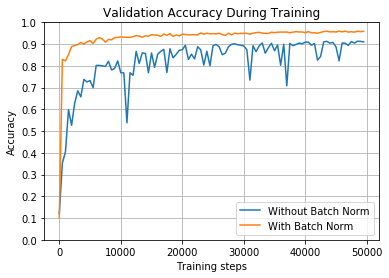

In [19]:
train_and_test(True, 2, tf.nn.sigmoid)

### Batch Normalization no arregla todo

Batch normalization no funciona en todos los casos. Los pesos siguen siendo aleatorios y los batches son elegidos aleatoriamente durante el entrenamiento, por lo que no sabes exactamente como irá el entrenamiento. Incluso para esas pruebas en donde usamos los mismos pesos iniciales para ambas redes, aún tenemos diferentes pesos cada vez que ejecutamos el código.

Esta sección incluye dos ejemplos que muestran lo que sucede cuando batch normalization no ayuda en nada.

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 1, y pesos de inicialización no razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:56<00:00, 282.93it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:02<00:00, 206.51it/s]


With Batch Norm: After training, final accuracy on validation set = 0.864799976348877
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8547000288963318


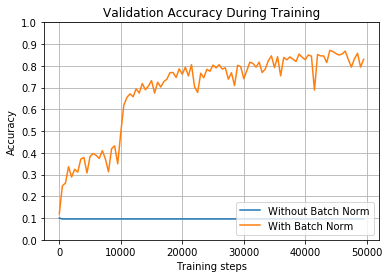

In [20]:
train_and_test(True, 1, tf.nn.relu)

Cuando utilizamos estos parámetros [previamente](#successful_example_lr_1), vimos que la red con batch normalization alcanzó el  92% de exactitud en la validación. Esta vez utilizamos diferentes pesos iniciales, con la misma desviación estándar al [ejemplo previo](#successful_example_lr_1), y la red no aprendió nada. 

**El siguiente ejemplo crea dos redes neuronales utilizando la función de activación ReLU, un learning rate de 2, y pesos de inicialización no razonables.**

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:49<00:00, 294.78it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:59<00:00, 208.35it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9223999977111816
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9111999869346619


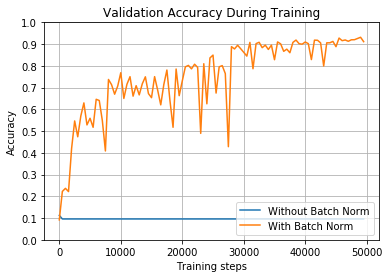

In [21]:
train_and_test(True, 2, tf.nn.relu)

Sucedió algo similar con [este ejemplo](#successful_example_lr_2). Los ejemplos mostrados en este notebook pretenden mostrar que batch normalization ayuda a entrenar mejor las redes neuronales artificiales. Pero estos últimos dos ejemplos pretenden demostrarte que debes elegir cuidadosamente la arquitectura de tus redes así como la inicialización de pesos.

# Batch Normalization a profundidad <a id='implementation_2'></a>

A continuación se da una breve explicación matemática de batch normalization. 

En orden de normalizar los valores, necesitamos primero encontrar el valor promedio para el batch. Es decir, el valor promedio que sale de cada capa antes de pasar por la función de activación no linear que posteriormente se convierte en la entrada de la siguiente capa.

Representamos el promedio como $\mu_B$, que es simplemente la suma de todos los valores $x_i$ dividido entre el número de valores, $m$ 

$$
\mu_B \leftarrow \frac{1}{m}\sum_{i=1}^m x_i
$$

Posteriormente, necesitamos calcular la varianza, o la raíz cuadrada de la desviación, representada como $\sigma_{B}^{2}$. 

Una vez que estimamos el promedio y la varianza, los usamos para normalizar los valores con la siguiente ecuación. Para cada valor, se le resta el promedio y se divide entre la _casi_ desviación estándar. 

$$
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \epsilon}}
$$

Mencionamos _casi_ desviación estándar porque la desviación estándar real para el batch está definida por $\sqrt{\sigma_{B}^{2}}$, pero la fórmula agrega el término _epsilon_, $\epsilon$, antes de calcular la raíz cuadrada. $\epsilon$ puede ser cualquier constante positiva pequeña - para nuestro código utilizamos `0.001`. Sirve parcialmente para evitar que no dividamos entre cero, pero también sirve para incrementar un poco la varianza de nuestro batch. 

Hasta este punto, tenemos un valor normalizado, representado como $\hat{x_i}$. Pero en lugar de usarlo directamente, lo multiplicamos por gamma, $\gamma$, y le sumamos beta, $\beta$. $\gamma$ y $\beta$ son parámetros aprendidos de la red y sirven para escalar y cambiar el valor de normalización, respectivamente. Debido a que son aprendidos al igual que los pesos, permiten afinar tu red durante el entrenamiento para ayudarle a aprender la función que busca aproximar.  

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

Ahora tenemos la capa de salida final con batch-normalization, que pasaremos a una función de activación no-lineal como sigmoide, tanh, ReLU, Leaky ReLU, etc. En la publicación original de batch normalization (citado previamente), mencionan que habrá casos en los que necesites implementar batch normalization _después_ de la no-linearidad en vez de antes, pero no es claro en la práctica.

En la implementación de `NeuralNet` con `fully_connected`, toda la matemática está oculta en las siguientes líneas, donde `linear_output` sirve como el $x_i$ de las ecuaciones:
```python
batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
```

# Consideraciones para otro tipo de redes

Este notebook utiliza batch normalization en una red neuronal estándar con capas conectadas completamente (fully connected layers). Sin embargo, puedes utilizar batch normalization en otro tipo de redes.

### ConvNets

Las redes __convolucionales__ o __CNNs__ consisten en mapas múltiples de características. (Recuerda, la profundidad de una capa convolucional se refiere al número de mapa de características o _feature map_). Y el peso para cada feature map es compartido a través de todas las entradas que alimentan la capa. Debido a estas difereencias, las capas convolucionales con batch normalization requieren un promedio de batch/población y varianza por feature map en lugar de por neurona (node) en la capa.

Cuando uses `tf.layers.batch_normalization`, asegúrate de prestar atención al orden de dimensiones convolucionales. Específicamente, debes establecer un valor diferente para el parámetro `axis` si tus capas tieinen sus canales al inicio en vez de al final. 